In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Загрузим уже обработанные в прошлом ДЗ данные!

In [2]:
df = pd.read_csv('processed_sigma.csv')
df = df.drop("Trip_ID", axis=1)

X = df.drop("Surge_Pricing_Type", axis=1)
y = df["Surge_Pricing_Type"]

### Principal component analysis (PCA)

**Задание 1.** Спроецируйте данные на двумерную плоскость, используя `PCA`. Другими словами, выделите первые две главные компоненты и изобразите данные в осях этих компонент. Не забудьте центрировать признаки перед применением метода. 

**Какую долю изначальной дисперсии (информации) содержат/объясняют в себе обе компоненты?** Для этого воспользуйтесь атрибутом `explained_variance_ratio_` у PCA-класса.

In [3]:
### Центрируем данные

### Your code is here

X_centered = X - X.mean()

In [4]:
from sklearn.decomposition import PCA

### Your code is here
pca = PCA(n_components=2).fit(X_centered)
pca.explained_variance_ratio_

array([0.63176117, 0.21129863])

**Задание 2.** Изобразите heatmap корреляции изначальных признаков с новыми двумя главными компонентами. \
**Какие признаки коррелируют с первой компонентой? Какие со второй? В качестве порогового значения договоримся о корреляции >= 0.5 по абсолютному значению **


<AxesSubplot:>

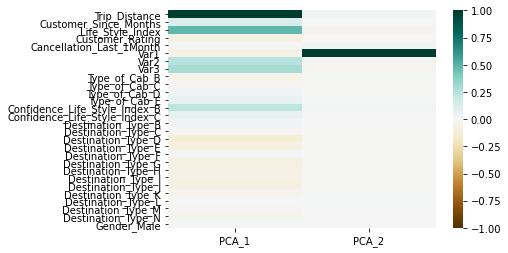

In [18]:
### Your code is here
import seaborn as sns

transformed = pd.DataFrame(pca.transform(X_centered), columns=['PCA_1', 'PCA_2'])
corr_1 = X_centered.corrwith(transformed['PCA_1'])
corr_2 = X_centered.corrwith(transformed['PCA_2'])

corrs = pd.concat([corr_1, corr_2], axis=1)
corrs.columns = ['PCA_1', 'PCA_2'] 

sns.heatmap(corrs, 
            xticklabels=corrs.columns,
            yticklabels=corrs.index,
            cmap='BrBG',
            vmin=-1,
            vmax=1)


**Задание 3.** Изобразите двумерную проекцию данных с метками классов. Выделите третью главную компоненту и аналогично нарисуйте трехмерную проекцию с метками классов. \
**Какие признаки коррелируют с третьей компонентой?**

<AxesSubplot:xlabel='PCA_1', ylabel='PCA_2'>

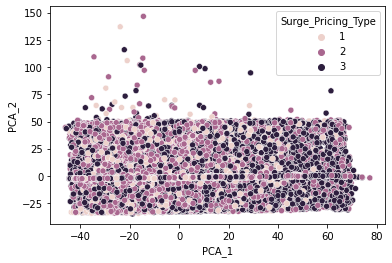

In [24]:
### Your code is here

pca_df = pd.concat([transformed, y], axis=1)
sns.scatterplot(data=pca_df, x="PCA_1", y="PCA_2", hue="Surge_Pricing_Type")

Советуем еще и замерить попарные корреляции между главными компонентами! Это поможет в ответе на один из тестовых вопросов.

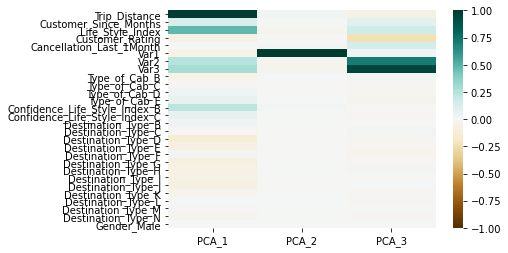

In [30]:
### Your code is here
pca = PCA(n_components=3).fit(X_centered)

transformed = pd.DataFrame(pca.transform(X_centered), columns=['PCA_1', 'PCA_2', 'PCA_3'])
corr_1 = X_centered.corrwith(transformed['PCA_1'])
corr_2 = X_centered.corrwith(transformed['PCA_2'])
corr_3 = X_centered.corrwith(transformed['PCA_3'])

corrs = pd.concat([corr_1, corr_2, corr_3], axis=1)
corrs.columns = ['PCA_1', 'PCA_2', 'PCA_3'] 

sns.heatmap(corrs, 
            xticklabels=corrs.columns,
            yticklabels=corrs.index,
            cmap='BrBG',
            vmin=-1,
            vmax=1)

pca_df = pd.concat([transformed, y], axis=1)

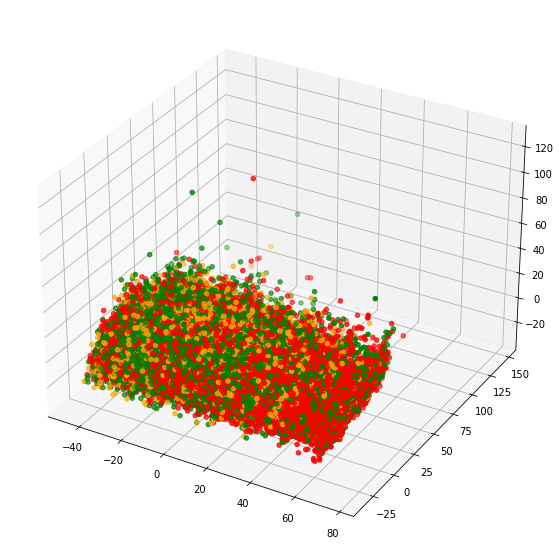

In [32]:
fig = plt.figure()
fig.set_size_inches(16, 10)

ax = plt.axes(projection='3d')

colors = pca_df['Surge_Pricing_Type'].replace([1,2,3],
                                            ['orange', 'green', 'red'])

ax.scatter3D(pca_df['PCA_1'], 
             pca_df['PCA_2'],
             pca_df['PCA_3'], 
             c=colors)

**Задание 4.** Обучите логистическую регрессию на первых двух компонентах центрированных данных и подберите гиперпараметры. Обучите логистическую регрессию на центрированных данных и подберите гиперпараметры. **Сравните метрику accuracy и f1-score на тестовой выборке в двух моделях**.

P.S. для удобства, скорости и нормализации данных (понадобится, так как захотим повалидироваться на параметрах регуляризации) можно построить конструкцию Pipeline c 3 следующими степами: StandardScaler -> PCA -> LogisticRegression

In [33]:
np.random.seed(2022)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_centered, y, test_size=0.2, 
                                                    shuffle=True, random_state=2022)

In [37]:
### Your code is here

param_grid = {'model__penalty': ['l1', 'l2', 'elasticnet'],
              'model__C': [1e-5, 0.0001, 0.001, 0.01]}

pca = PCA(n_components=2).fit(X_train)
X_train_2 = pca.transform(X_train)

pipe_def = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

pipe_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('model', LogisticRegression())
])

grid_def = GridSearchCV(pipe_def, param_grid).fit(X_train_2, y_train)
grid_pca = GridSearchCV(pipe_pca, param_grid).fit(X_train, y_train)

In [43]:
print(classification_report(y_test, grid_def.predict(pca.transform(X_test)), digits=3))

              precision    recall  f1-score   support

           1      0.000     0.000     0.000      5372
           2      0.456     0.830     0.589     11349
           3      0.493     0.291     0.366      9612

    accuracy                          0.464     26333
   macro avg      0.316     0.374     0.318     26333
weighted avg      0.376     0.464     0.387     26333



In [44]:
print(classification_report(y_test, grid_pca.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.000     0.000     0.000      5372
           2      0.478     0.690     0.565     11349
           3      0.493     0.511     0.502      9612

    accuracy                          0.484     26333
   macro avg      0.324     0.400     0.356     26333
weighted avg      0.386     0.484     0.427     26333



Кажется, достаточно сильно теряем в качестве! Может, добавить компонент?

**Задание 5.** Обучите модели логистической регресии на нескольких различных компонентах: [2, 4, 8, 16, 28]. **Нарисуйте графики зависимости accuracy, f1-score от количества компонент. Введите их значения через запятую**. При обучении используйте l2-регуляризацию, гиперпараметр C подбирайте по сетке. 


In [46]:
### Чтобы не заставлять вас писать похожий на предыдущий код,
### Написали функцию, которая будет обучать модель для
### произвольного числа n_components главных компонент.

def train_pca_i(n_components, X_train, y_train):
    pipe = Pipeline([('scaler', StandardScaler()), 
                     ('pca', PCA(n_components=n_components)),
                     ('model', LogisticRegression(penalty='l2', solver='saga',random_state=1))])
    
    param_grid = {'model__C': [0.0001, 0.001, 0.01, 0.1]}
    
    grid = GridSearchCV(pipe, param_grid, cv=5)
    grid.fit(X_train, y_train)
    
    report = classification_report(y_test, grid.predict(X_test), output_dict=True)
    return (report['accuracy'], 
            report['weighted avg']['f1-score'])

In [47]:
%%time
accuracy_dict, f1_score_dict = {}, {}
components_list = [2, 4, 8, 16, 28]

for n_components in components_list:
    
    ### Your code is here
    rep = train_pca_i(n_components, X_train, y_train)
    accuracy_dict[n_components] = rep[0]
    f1_score_dict[n_components] = rep[1]

CPU times: user 4min 18s, sys: 2min 39s, total: 6min 58s
Wall time: 4min 7s


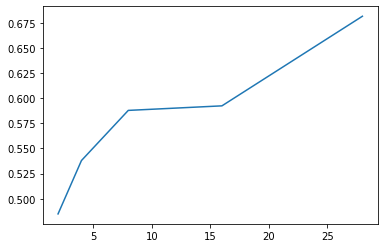

In [48]:
plt.plot(list(accuracy_dict.keys()), list(accuracy_dict.values()))

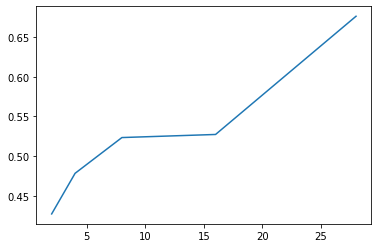

In [49]:
plt.plot(list(f1_score_dict.keys()), list(f1_score_dict.values()))

In [51]:
round(f1_score_dict[28],3 )

0.676

Обычно, когда решается какая-то высокоразмерная предсказательная задача, где тысячи признаков, функция качества PCA моделей похожа на параболу ветвями вниз в зависимости от количества компонент (для совсем маленьких и больших n_component качество маленькое, при этом есть где-то промежуточное значение).

Как думаете, почему здесь у нас непрерывно растущие графики качества?

Может, изначальные признаки были слишком хороши?

### t-SNE

Напомним, что метод заключается в введении некоторых функций, основанных на расстоянии между признаками, которые измеряют близость объектов. Функций, как вы помните, две, и они заданы в исходном и новом пространствах соотвественно. Далее минимизируем дивергенцию Кульбака-Лейблера по координатaм в новом пространстве

**Задание 6.** Обучите t-sne c `n_components=2` на изначальных данных и визуализируйте результаты с учетом известных классов. 

P.S. если устанете ждать обучения TSNE, или упадет ошибка по типу oom, то можно сократить число объектов в датасете до, например, пары тысяч. Это и следующее задания никак проверяться системой не будут. Вам достаточно повторить упражнение с практики и получить какое-то более адекватное (по сравнению с PCA) изображение классов.

In [6]:
from sklearn.manifold import TSNE

### Your code is here



**Задание 7.** Обучите t-sne с `n_components=3` на изначальных данных и визуализируйте результаты с учетом известных классов.

In [7]:
### Your code is here



Советуем обрезать датасет до маленького числа объектов (чтобы точки и их группки были хорошо различимы) и поиграться с гиперпараметрами класса Tsne! Обычно такая "игра" может привести к куда более красивым результатам по сравнению с теми, что получены с дефолтными настройками!